In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [3]:
import pandas as pd

df = pd.read_csv("spam.csv")

df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [8]:
df.groupby("Category").describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [13]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [14]:
# We can see that there our data is imbalance, so we need to implement some technique we studied earlier to handel this imbalance.
# We are here using the undersampling technique

df_ham = df[df.Category=='ham']
df_spam = df[df.Category=='spam']

print(df_ham.shape, df_spam.shape)

(4825, 2) (747, 2)


In [19]:
df_ham_under = df_ham.sample(df_spam.shape[0])
df_ham_under.shape

(747, 2)

In [23]:
df_under = pd.concat([df_spam, df_ham_under])
df_under

,Category,Message
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
3576,ham,And do you have any one that can teach me how ...
3004,ham,I will see in half an hour
3398,ham,Heehee that was so funny tho
2394,ham,"Okey doke. I'm at home, but not dressed cos la..."


In [24]:
# Shuffling the data
df_under = df_under.sample(frac=1)
df_under

,Category,Message
538,ham,Or maybe my fat fingers just press all these b...
3468,spam,URGENT! We are trying to contact U. Todays dra...
879,spam,U have a secret admirer who is looking 2 make ...
881,spam,Reminder: You have not downloaded the content ...
738,spam,Hi. Customer Loyalty Offer:The NEW Nokia6650 M...
...,...,...
5378,spam,Free entry to the gr8prizes wkly comp 4 a chan...
4491,ham,My computer just fried the only essential part...
4359,spam,Our dating service has been asked 2 contact U ...
5528,ham,Its just the effect of irritation. Just ignore it


In [25]:
df_under['spam'] = df.Category.apply(lambda x: 1 if x=='spam' else 0)

df_under

,Category,Message,spam
538,ham,Or maybe my fat fingers just press all these b...,0
3468,spam,URGENT! We are trying to contact U. Todays dra...,1
879,spam,U have a secret admirer who is looking 2 make ...,1
881,spam,Reminder: You have not downloaded the content ...,1
738,spam,Hi. Customer Loyalty Offer:The NEW Nokia6650 M...,1
...,...,...,...
5378,spam,Free entry to the gr8prizes wkly comp 4 a chan...,1
4491,ham,My computer just fried the only essential part...,0
4359,spam,Our dating service has been asked 2 contact U ...,1
5528,ham,Its just the effect of irritation. Just ignore it,0


In [26]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_under['Message'], df_under['spam'], stratify=df_under['spam'])

In [28]:
x_train.head(5)

3682             LOL what happens in Vegas stays in vegas
2203    (And my man carlos is definitely coming by mu ...
4125    Hey sexy buns ! Have I told you ? I adore you,...
5468    URGENT! Last weekend's draw shows that you hav...
840     Last chance 2 claim ur £150 worth of discount ...
Name: Message, dtype: object

In [29]:
'''
BERT (Bidirectional Encoder Representations from Transformers), ML technique for natural language processing pre-training developed by Google
'''

bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [37]:
'''
keys of the dictionary output by the bert_encoder 
['default', 'encoder_outputs', 'pooled_output', 'sequence_output']
'''

def get_sentence_embedding(sentence):
    processed = bert_preprocess(sentence)
    return bert_encoder(processed)['pooled_output']

In [38]:
get_sentence_embedding(["I didn't like it, totally aweful", "I loved it very very much"])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8153052 , -0.18276429, -0.6920952 , ..., -0.64340746,
        -0.49640974,  0.88203627],
       [-0.90444356, -0.26237443, -0.5442358 , ..., -0.38714865,
        -0.66547525,  0.92229354]], dtype=float32)>

<b style="color:lightgreen"><i>Finally, Building the Model</i></b>

In [41]:
'''
This time we'll use function style of building the neural netwok model, In these the previous layer is work as an input to the next layer.
'''
from tensorflow.keras import layers, models

input = layers.Input(shape=(), dtype=tf.string, name='input_layer')
preprocessed = bert_preprocess(input)
outputs = bert_encoder(preprocessed)

l1 = layers.Dropout(0.1, name='Dropout')(outputs['pooled_output'])
l2 = layers.Dense(1, activation='sigmoid', name='output_layer')(l1)


model = models.Model(inputs=[input], outputs=[l2])

In [42]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['input_layer[0][0]']            
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [43]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS
)

In [45]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
35/35 [==============================] - 648s 18s/step - loss: 0.5941 - accuracy: 0.7188 - precision: 0.7316 - recall: 0.6911
Epoch 2/5
35/35 [==============================] - 685s 19s/step - loss: 0.4903 - accuracy: 0.8384 - precision: 0.8164 - recall: 0.8732
Epoch 3/5
35/35 [==============================] - 638s 18s/step - loss: 0.4303 - accuracy: 0.8491 - precision: 0.8297 - recall: 0.8786
Epoch 4/5
35/35 [==============================] - 321s 9s/step - loss: 0.3914 - accuracy: 0.8670 - precision: 0.8537 - recall: 0.8857
Epoch 5/5
35/35 [==============================] - 503s 14s/step - loss: 0.3559 - accuracy: 0.8911 - precision: 0.8699 - recall: 0.9196


In [46]:
model.evaluate(x_test,y_test)

12/12 [==============================] - 172s 13s/step - loss: 0.3246 - accuracy: 0.9037 - precision: 0.8756 - recall: 0.9412


[0.32461127638816833,
 0.903743326663971,
 0.8756219148635864,
 0.9411764740943909]

In [47]:
y_p = model.predict(x_test)
y_p = y_p.flatten()


import numpy as np
y_pred = np.where(y_p > 0.5, 1, 0)

12/12 [==============================] - 187s 16s/step


In [48]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)
cm 

array([[162,  25],
       [ 11, 176]], dtype=int64)

Text(33.0, 0.5, 'Truth')

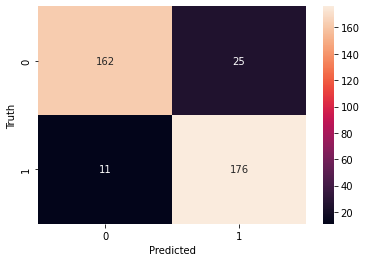

In [49]:
import matplotlib.pyplot as plt
import seaborn as sb
sb.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.87      0.90       187
           1       0.88      0.94      0.91       187

    accuracy                           0.90       374
   macro avg       0.91      0.90      0.90       374
weighted avg       0.91      0.90      0.90       374



In [51]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 6s 6s/step


array([[0.7540017 ],
       [0.791283  ],
       [0.80119073],
       [0.35600248],
       [0.21365757]], dtype=float32)